## Ejercicio

La tabla _frame_rotator_source_ del archivo EDR3 de Gaia contiene una lista de identificadores para 429,249 fuentes que se han clasificado como cuásares. Cruzando esta tabla con la tabla principal de EDR3 _gaia_source_ podemos extraer la inforación que necesitamos para estos objetos:

    select QSO.source_id, G.parallax, G.parallax_error, G.phot_g_mean_mag, G.nu_eff_used_in_astrometry, 
           G.pseudocolour, G.ecl_lat, G.astrometric_params_solved
    from gaiaedr3.frame_rotator_source as QSO
    JOIN gaiaedr3.gaia_source as G
    using (source_id)

En este tutorial proporcionamos el resultado en el fichero _QSO_Data.csv_. 

Usando estos datos podemos comprobar como la corrección que hemos presentado elimina casi totalmente el sesgo de punto cero:

1. Hacer un histograma y un QQ-plot de las paralajes normalizadas ($\varpi/\sigma_\varpi$) para comprobar que su distribución es muy aproximadamente normal 
2. Calcular la media de las paralajes sin corrección y con corrección 

En el primer caso la media es aproximadamente $-0.017mas$, mientras que en el segundo es casi cero. Con esto se comprueba la validez de la corrección, puesto que los cuásares (debido a su gran distancia) tienen paralajes de valor cero, por lo que la media debe acercarse a este valor.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab

import zpt
zpt.load_tables()

## Leemos los datos

In [49]:
data = pd.read_csv('QSO_Data.csv')

parallax = data['parallax'].values
parallax_error= data['parallax_error'].values
gmag = data['phot_g_mean_mag'].values
nueffused = data['nu_eff_used_in_astrometry'].values
psc = data['pseudocolour'].values
ecl_lat = data['ecl_lat'].values
soltype = data['astrometric_params_solved'].values

## Usamos la función zpt para obtener las correcciones de punto cero

No hay fuentes con soluciones 2-p en este caso, de forma que por simplicidad podemos usar _get_zpt()_ sin preocuparnos de filtrarlas. 


__Opcional:__ 

Como se detalla en Lindegren et al. 2021, las interpolaciones estan calibradas solo en los siguientes intervalos.

1. magnitud $G$: 
    6 < phot_g_mean_mag < 21
2. Color:
    1. 1.1 < nu_eff_used_in_astrometry < 1.9 (fuentes 5-p)
    2. 1.24 < pseudocolour < 1.72 (fuentes 6-p)
        
Fuera de estos rangos la corrección de punto cero es una **extrapolación** 

Como ejercicio adicional podemos eliminar las fuentes fuera de rango (extrapolaciones) para mejorar la estimación, pero afecta a muy pocos valores (10) i no es relevante para este ejercicio.

In [50]:
zpvals = zpt.get_zpt(gmag, nueffused, psc, ecl_lat, soltype)

C:\Google Drive\UB\Gaia\Congressos i reunions\Escuela LatAm 2022\Tutoriales\PuntoCero\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(
C:\Google Drive\UB\Gaia\Congressos i reunions\Escuela LatAm 2022\Tutoriales\PuntoCero\zpt.py:220: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
                mag). Outside this range, the zero-point calculated can be seriously wrong.
  warnings.warn(


## Comprobación de la normalidad de la distribución de $\varpi/\sigma_\varpi$

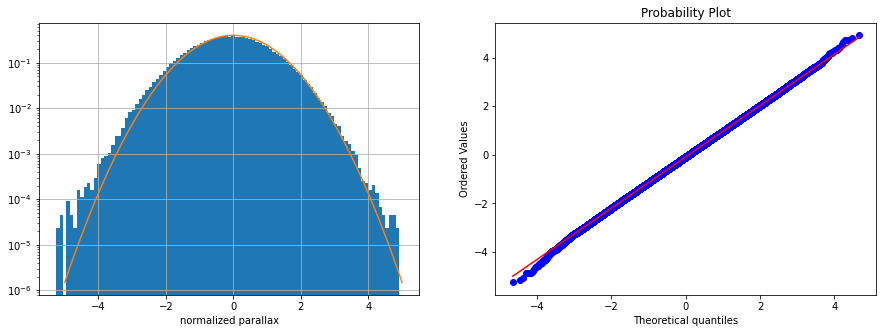

In [68]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)
plt.yscale("log")

plt.xlabel("normalized parallax")
plt.grid()
plt.hist(parallax/parallax_error,bins=100,density=True)

# Add reference line with sero mean, unit variance normal
x= np.linspace(-5,5,100)
y= np.exp(-x*x/2)/(2*math.pi)**0.5
plt.plot(x,y)


plt.subplot(1,2,2)
stats.probplot(parallax/parallax_error, dist="norm", plot=pylab)

plt.show()

## Comparación de las medias

Media sin corrección: -0.01828
Media con corrección: -0.00026


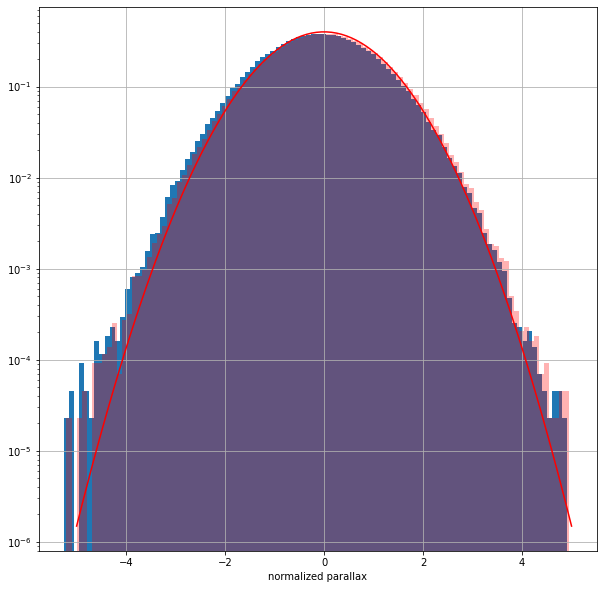

In [71]:
print("Media sin corrección: {:8.5f}".format(sum(parallax)/len(parallax)))
print("Media con corrección: {:8.5f}".format(sum(parallax-zpvals)/len(parallax)))

plt.rcParams["figure.figsize"] = (10,10)

plt.yscale("log")
plt.xlabel("normalized parallax")
plt.hist((parallax)/parallax_error,bins=100,density=True)
plt.hist((parallax-zpvals)/parallax_error,bins=100,fc=(1, 0, 0, 0.3),density=True)

# Add reference line with sero mean, unit variance normal
x= np.linspace(-5,5,100)
y= np.exp(-x*x/2)/(2*math.pi)**0.5
plt.plot(x,y,"r-")

plt.grid()

plt.show()